In [3]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Validação Cruzada

A validação cruzada é um meta-protocolo que combina métricas de predição de conjuntos de teste obtidas a partir do mesmo modelo de aprendizagem de máquina sobre diferentes partições da base de dados. As métricas são normalmente combinadas usando medidas estatísticas como média e desvio padrão, que representam uma estimativa do desempenho do modelo em dados que não foram utilizadas para treinar o modelo. Estas medidas podem ser usadas em testes estatísticos para selecionar o melhor modelo para usar na prática. Um dos protocolos de validação cruzada mais amplamente utilizados é a *validação cruzada em k-vias*.

## Validação Cruzada em k-vias (*K-fold cross validation*)

Com a validação cruzada em k-vias, a base de dados é aleatoriamente particionada em $k$ subconjuntos, todos aproximadamente contendo a mesma quantidade de elementos. Opcionalmente, os dados podem ser embaralhados e o particionamento pode ser feito de forma estratificada. Cada subconjunto é conhecido como uma **via** ou **pasta** (em inglês: ***fold***). $k$ particionamentos em conjuntos de treino e teste são criados. Em cada particionamento, o conjunto de teste assume uma única via, e o restante das $k-1$ vias são usadas como conjunto de treinamento. Cada particionamento utiliza uma via diferente como conjunto de teste, e cada conjunto de teste é utilizado apenas uma única vez durante o procedimento. Desta forma, todss os instâncias da base de dados são utilizadas para avaliar o modelo e cada instância é usada uma única vez. A Figura abaixo mostra um esquema dos particionamentos realizados com validação cruzada em 4 vias ($k=4$).

<div align='center'>
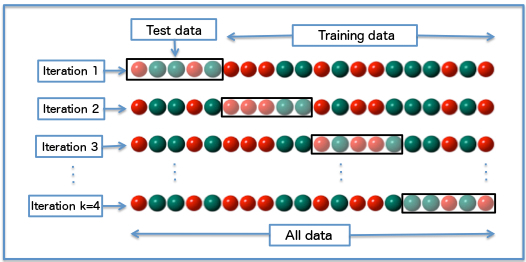
</div>


In [4]:
ds = load_iris(as_frame=True)
df = ds.frame
X = ds.data.values
y = ds.target.values

Vamos fazer a otimização do hiperparâmetro $k$ do KNN, como na última aula.

In [5]:
def selecionar_melhor_k(ks, X_treino, X_val, y_treino, y_val):
    acuracias_val = []

    for k in ks:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_treino, y_treino)
        pred = knn.predict(X_val)
        acuracias_val.append(accuracy_score(y_val, pred))
        
    melhor_val = max(acuracias_val)
    melhor_k = ks[np.argmax(acuracias_val)]        
    knn = KNeighborsClassifier(n_neighbors=melhor_k)
    knn.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])
    
    return knn, melhor_k, melhor_val

A biblioteca sklearn oferece vários protocolos de validação cruzada. O código a seguir mostra como usar a validação cruzada estratificada (implementada na classe ``StratifiedKFold`` do módulo ``model_selection``). O método ``split`` gera os índices das instâncias que devem ser usadas para treinamente e teste, respectivamente. Esta class faz o particionamento estratificado, ou seja, procura manter as proporções das instâncias entre as classes da base de dados toda nos conjuntos de treinamento e teste.

Não existe um número certo de vias que devemos dividir a base de dados para realizar a validação cruzada. Entretanto, é comum dividir a base de dados em 10 vias. Note no código abaixo que usamos ``n_splits=10``, que instrui o sklearn a fazer o particionamento em 10 vias.

In [6]:
#a validação cruzada será realizada em 10 vias.
k_vias = 10

#usar o protocolo de validação cruzada estratificada
skf = StratifiedKFold(n_splits=k_vias, shuffle=True, random_state=1)

acuracias = []

#a função split retorna os índices das instâncias que devem ser usadas para o treinamento e o teste.
for idx_treino, idx_teste in skf.split(X, y):
    
    #extrair as instâncias de treinamento de acordo com os índices fornecidos pelo skf.split
    X_treino = X[idx_treino]
    y_treino = y[idx_treino]
    
    #extrair as instâncias de teste de acordo com os índices fornecidos pelo skf.split
    X_teste = X[idx_teste]
    y_teste = y[idx_teste]
    
    #separar as instâncias de treinamento entre treinamento e validação para a otimização do hiperparâmetro k
    X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, test_size=0.2, stratify=y_treino, shuffle=True, random_state=1)
    
    #colocar todas as variáveis na mesma escala, usando o conjunto de treinamento para calcular os parâmetros da escala
    ss = StandardScaler()
    ss.fit(X_treino)
    X_treino = ss.transform(X_treino)
    X_teste = ss.transform(X_teste)
    X_val = ss.transform(X_val)

    #escolher o k com o melhor resultado no conjunto de validação e treinar o KNN com o melhor k.
    knn, _, _ = selecionar_melhor_k(range(1,30,2), X_treino, X_val, y_treino, y_val)
    
    #calcular a acurácia no conjunto de testes desta iteração e salvar na lista.
    acuracias.append(accuracy_score(y_teste, knn.predict(X_teste)))
    
#calcular as estatísticas da validação cruzada. Estas estatísticas nos dão uma confiança que, na média, este é o desempenho esperado
#do classificador no mundo real.
print("min: %.2f, max: %.2f, avg +- std: %.2f+-%.2f" % (min(acuracias), max(acuracias), np.mean(acuracias), np.std(acuracias)))
    

min: 0.87, max: 1.00, avg +- std: 0.94+-0.05


O resultado obtido no exemplo anterior nos diz que podemos esperar que nosso classificador acerte entre 89% e 99% dos casos no mundo real.

Veja que no exemplo anterior usamos um único conjunto de validação para otimizar o valor de $k$ em cada iteração da validação cruzada. Uma alternativa é usar validação cruzada em k-vias no conjunto de treinamento para obter uma estimativa da melhor combinação de parâmetros na via de validação. Desta forma, teremos uma validação cruzada em dois níveis: no nível "de fora" teremos a validação cruzada em k-vias para avaliar os $k_1$ particionamentos da base de dados. No nível "de dentro" teremos a validação cruzada em $k_2$ vias para avaliar cada combinação de parâmetros no conjunto de treinamento atual, particionando-o em $k_2$ vias de validação. O código abaixo representa este procedimento.

A biblioteca *sklearn* oferece a validação cruzada para a otimização de hiperparâmetros por busca exaustiva pela classe ``GridSearchCV`` do módulo ``model_selection``.

In [8]:
from sklearn.model_selection import GridSearchCV #busca exaustiva para otimização de hiperparâmetro por validação cruzada

k1 = 10 #controla o número de vias da validação cruzada para estimar o desempenho do modelo
k2 = 10 #controla o número de vida da validação cruzada para otimização de hiperparametros

#usar o protocolo de validação cruzada estratificada
skf = StratifiedKFold(n_splits=k1, shuffle=True, random_state=1)

acuracias = []

#a função split retorna os índices das instâncias que devem ser usadas para o treinamento e o teste.
for idx_treino, idx_teste in skf.split(X, y):
    
    #extrair as instâncias de treinamento de acordo com os índices fornecidos pelo skf.split
    X_treino = X[idx_treino]
    y_treino = y[idx_treino]
    
    #extrair as instâncias de teste de acordo com os índices fornecidos pelo skf.split
    X_teste = X[idx_teste]
    y_teste = y[idx_teste]
    
    #colocar todas as variáveis na mesma escala, usando o conjunto de treinamento para calcular os parâmetros da escala
    ss = StandardScaler()
    ss.fit(X_treino)
    X_treino = ss.transform(X_treino)
    X_teste = ss.transform(X_teste)
    
    #combinações de parametros otimizar. Aqui estamos apenas otimizando o número de vizinhos mais próximos para o knn (k).
    #Entretanto, podemos colocar todos os valores de todos os parametros. O sklearn se encarrega de gerar todas as combinações.
    params = {'n_neighbors' : range(1,30,2)}
    #instanciar um KNN com parametros padrão
    knn = KNeighborsClassifier()
    #instanciar um GridSearchCV com k2 vias.
    knn = GridSearchCV(knn, params, cv=StratifiedKFold(n_splits=k2))
    #realizar a otimização dos hiperparâmetros e treinar o modelo final com a melhor combinação de hiperparametros com todos os dados de treinamento
    knn.fit(X_treino, y_treino)
    
    #calcular a acurácia no conjunto de testes desta iteração e salvar na lista.
    acuracias.append(accuracy_score(y_teste, knn.predict(X_teste)))
    
#calcular as estatísticas da validação cruzada. Estas estatísticas nos dão uma confiança que, na média, este é o desempenho esperado
#do classificador no mundo real.
print("min: %.2f, max: %.2f, avg +- std: %.2f+-%.2f" % (min(acuracias), max(acuracias), np.mean(acuracias), np.std(acuracias)))


min: 0.87, max: 1.00, avg +- std: 0.95+-0.05


Note que houve uma pequena diferença na média dos resultados ao escolhermos o valor de $k$ usando validação cruzada. Por outro lado, notamos que o treinamento e validação do modelo nos particionamentos diferentes demora bem mais tempo. A escolha entre fazer a validação cruzada para a seleção dos hiperparâmetros ou apenas um único particionamento do conjunto de treino em treino e validação fica a critério do projetista do sistema, podendo ou não fazer muita diferença no resultado final.

Em resumo, as estatísticas obtidas com a validação cruzada sobre os diferentes particionamentos da base de dados nos dão uma idéia do desempenho do classificador (modelo) na prática. Portanto, estas estatísticas podem ser usadas para comparar os resultados esperados de modelos diferentes que foram projetados para resolver o mesmo problema. Estas estatísticas nos permitem fazer a escolha do modelo que mais provavelmente será melhor na prática. Para isso podemos usar testes estatísticos. Estudaremos um teste amplamente utilizado neste contexto em breve.